In [2]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from util.dataset import ECL
from util.metrics import MAE, MSE
% matplotlib inline

UsageError: Line magic function `%` not found.


In [3]:
def cross_valid(data, training_len, predict_len, sample_n, show=False):
    L, N = data.shape
    total_len = training_len + predict_len
    stride = (L - total_len) // ((sample_n - 1) if sample_n > 1 else 1)

    preds = np.zeros((sample_n, predict_len))
    gts = np.zeros((sample_n, predict_len))
    for i in range(sample_n):
        data_part = data.iloc[stride * i:stride * i + total_len, :]
        train_data, test_data = data_part.iloc[:-predict_len, :], data_part.iloc[-predict_len:, :]

        m = Prophet()
        m.fit(train_data)
        future = m.make_future_dataframe(periods=predict_len, freq="H")  # shape: (len(train_data) + pre_len, 2)
        forecast = m.predict(future)

        pred = np.array(forecast.yhat[-predict_len:])
        ground_truth = np.array(test_data.iloc[:, 1])
        if show:
            plt.plot(pred, label="Pred")
            plt.plot(ground_truth, label="GT")
            plt.legend()

        preds[i] = pred
        gts[i] = ground_truth

    mse = np.mean(MSE(preds, gts))
    mae = np.mean(MAE(preds, gts))
    mtc = {"mse": mse, "mae": mae}
    return mtc


def predict(training_data: pd.DataFrame, testing_data: pd.DataFrame, show=True):
    train_len, pre_len = training_data.shape[0], testing_data.shape[0]

    m = Prophet()
    m.fit(mt320_training)

    future = m.make_future_dataframe(periods=pre_len, freq="H")  # shape: (len(train_data) + pre_len, 2)
    # print(future.tail())

    forecast = m.predict(future)  # ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    # print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

    pred = np.array(forecast.yhat[-pre_len:])
    ground_truth = np.array(testing_data.iloc[:, 1])

    mtc = dict()
    mtc["mse"] = MSE(pred, ground_truth)
    mtc["mae"] = MAE(pred, ground_truth)

    if show:
        plt.plot(pred, label="Pred")
        plt.plot(ground_truth, label="GT")
        plt.legend()

    return m, mtc

# ECL

In [7]:
# normalize
ecl_data = ECL().df

scaler = StandardScaler()
ecl_data_norm = scaler.fit_transform(ecl_data.iloc[:, 1:])

ecl_data.iloc[:, 1:] = ecl_data_norm
ecl_data.head()
print(ecl_data.shape)

(26304, 322)


## 1. univariate long sequence time-series

15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing


{'mse': array([0.09515903]), 'mae': array([0.25250022])}


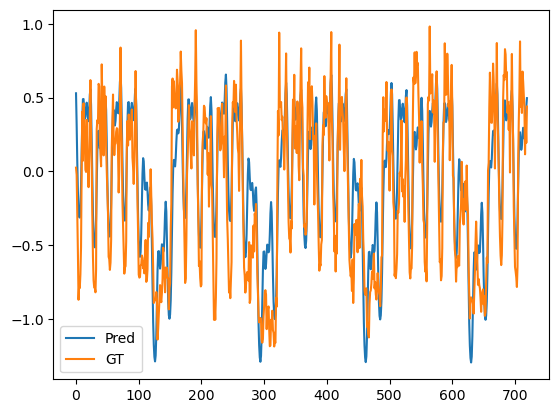

In [5]:
pre_len, train_len, offset = 720, 720, 0
# mt320 = ecl_data.iloc[-(train_len + pre_len) - offset:-offset if offset != 0 else None, [0, -1]].rename(
#     columns={"date": "ds", "MT_320": "y"})

mt320 = ecl_data.iloc[:(train_len + pre_len), [0, -1]].rename(
    columns={"date": "ds", "MT_320": "y"})
mt320_training = mt320.iloc[:-pre_len, :]
mt320_testing = mt320.iloc[-pre_len:, :]
# print(mt320.head(5))

model, metrics = predict(mt320_training, mt320_testing)
print(metrics)

In [8]:
mt320_all = ecl_data.iloc[:, [0, -1]].rename(columns={"date": "ds", "MT_320": "y"})
pre_len, train_len = 720, 720
metric = cross_valid(mt320_all, train_len, pre_len, 500)
print(metric)

15:12:01 - cmdstanpy - INFO - Chain [1] start processing
15:12:01 - cmdstanpy - INFO - Chain [1] done processing
15:12:02 - cmdstanpy - INFO - Chain [1] start processing
15:12:02 - cmdstanpy - INFO - Chain [1] done processing
15:12:02 - cmdstanpy - INFO - Chain [1] start processing
15:12:02 - cmdstanpy - INFO - Chain [1] done processing
15:12:03 - cmdstanpy - INFO - Chain [1] start processing
15:12:03 - cmdstanpy - INFO - Chain [1] done processing
15:12:04 - cmdstanpy - INFO - Chain [1] start processing
15:12:04 - cmdstanpy - INFO - Chain [1] done processing
15:12:04 - cmdstanpy - INFO - Chain [1] start processing
15:12:04 - cmdstanpy - INFO - Chain [1] done processing
15:12:05 - cmdstanpy - INFO - Chain [1] start processing
15:12:05 - cmdstanpy - INFO - Chain [1] done processing
15:12:05 - cmdstanpy - INFO - Chain [1] start processing
15:12:06 - cmdstanpy - INFO - Chain [1] done processing
15:12:06 - cmdstanpy - INFO - Chain [1] start processing
15:12:06 - cmdstanpy - INFO - Chain [1]

{'mse': 1.3585766440726825, 'mae': 0.8031047365574643}


In [9]:
print(metric)

{'mse': 1.3585766440726825, 'mae': 0.8031047365574643}


# WHT